In [1]:
import shap
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from validclust import dunn
from pySankey.sankey import sankey  
from scipy.cluster.hierarchy import dendrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances,silhouette_score

np.random.seed(20) 

# Read Computed RSCA values

In [2]:
# The first 73 columns of the table include the various mobile services under consideration for each one of the 4762 indoor antennas in our data set
# The last column comprises the environment of the indoor antennas

df_RSCA = pd.read_csv("data/Antennas_RSCA.csv")
RSCA  = df_RSCA[df_RSCA.columns[:-1]]

Text(0.5, 1.0, ' Mobile Serivce RSCA correlation')

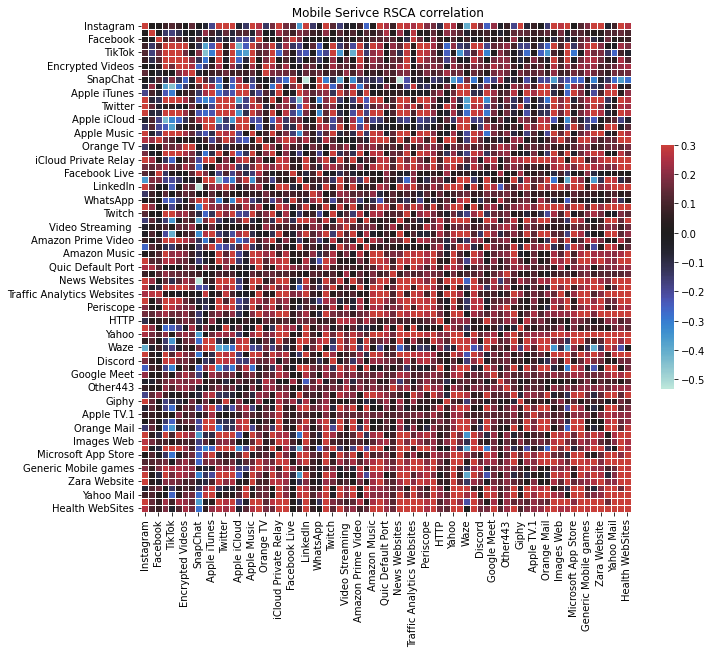

In [3]:
# Applications Correlation


cmap = sns.diverging_palette(230, 20, as_cmap=True) 
corr = RSCA.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))


sns.heatmap(corr,   vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title(" Mobile Serivce RSCA correlation")

# Cluster Antennas Based on their RSCA

In [4]:
kmax = 30 

sil_RSCA = []
ks = []
dun_RSCA = [] 
  
 
for k in range(2, kmax+1):
   Hier_Clust =AgglomerativeClustering(n_clusters = k, linkage = "ward",
                                   compute_distances=True).fit(RSCA )
  
   labels = Hier_Clust.labels_ 
   sil_RSCA.append(silhouette_score(RSCA, labels, metric = 'euclidean')) 

   dist = pairwise_distances(RSCA )
   dun_RSCA.append( dunn(dist, labels)  )
   
   ks.append(k) 


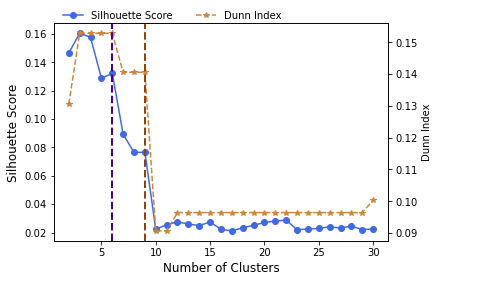

In [5]:
fig,ax = plt.subplots()
ax.plot(ks, sil_RSCA, color = "royalblue"  ,
         marker="o", label = "Silhouette Score")
plt.legend( )

# set x-axis label
ax.set_xlabel("Number of Clusters" , fontsize = 12 )
ax.set_ylabel("Silhouette Score" , fontsize = 12 )
 
ax2=ax.twinx()
   
ax2.plot(ks, dun_RSCA,color="peru",  linestyle='dashed', marker="*", label = "Dunn Index")
ax2.set_ylabel("Dunn Index" )



ax.legend(loc='lower left', mode = "expand",  bbox_to_anchor=(0, 0.97, 0.8, 0.0),
           frameon=False,ncol=3)

ax2.legend(loc='lower left', mode = "expand",  bbox_to_anchor=(0.4, 0.97, 0.9, 0.0),
           frameon=False, ncol=3)

plt.axvline(x=6,  linestyle = '--', linewidth = 2, color = "indigo")
plt.axvline(x=9,  linestyle = '--', linewidth = 2, color = "saddlebrown" )

In [6]:
classes =9
Hier_Clust = AgglomerativeClustering(n_clusters = classes,linkage = "ward",
                                  compute_distances=True).fit(RSCA)
  
labels = Hier_Clust.labels_
 

NameError: name 'sa' is not defined

In [ ]:
plt.figure(figsize=(25,14))

from scipy.cluster.hierarchy import dendrogram, linkage
dendrogram(linkage(RSCA , 'ward'),
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True, 
            p = 3)

plt.show()

KeyboardInterrupt: 

Text(0, 0.5, 'Application ID')

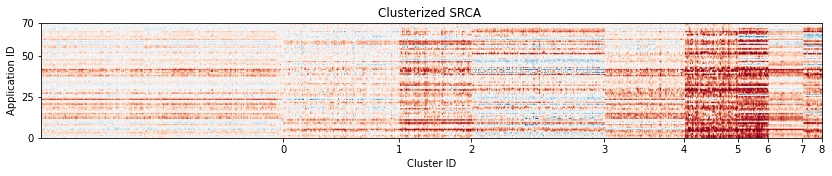

In [ ]:
RSCA_ = np.zeros([df_RSCA.shape[0], df_RSCA.shape[1]])
RSCA_[:,:-1] = RSCA
RSCA_ [:,-1] =  labels
RSCA_ = RSCA_[RSCA_[:, -1].argsort()]

x_list = []
for j in range(1, len(RSCA_[:,-1])):
    if RSCA_[j,-1] != RSCA_[j-1,-1]:
        x_list.append(j)
x_list.append(j)

fig, ax = plt.subplots(1,1, figsize=(14,17))
img = ax.imshow( RSCA_[:,:-1].transpose() , cmap='RdBu', extent = [ 0, len(RSCA), 0, 700 ]
                ,vmin  =-1 , vmax = 1)

y_label_list = ['0', '25', '50', '70']
x_label_list = ['0', '1', '2', '3',
                '4', '5', '6', '7', 
                 '8' ]
ax.set_xticks(x_list)

ax.set_yticks([ 0, 250, 500, 700])
 
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_title("Clusterized SRCA ")
ax.set_xlabel("Cluster ID")
ax.set_ylabel("Application ID")

# Explain CLuster via SHAP

In [ ]:
# Fit a random forest algorithm to replicate the clustering results 

clf=RandomForestClassifier()
clf.fit(RSCA, np.squeeze(  labels))



RandomForestClassifier()

In [ ]:
# Estimate shap values for the predictions of the clustering algorith
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(RSCA)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


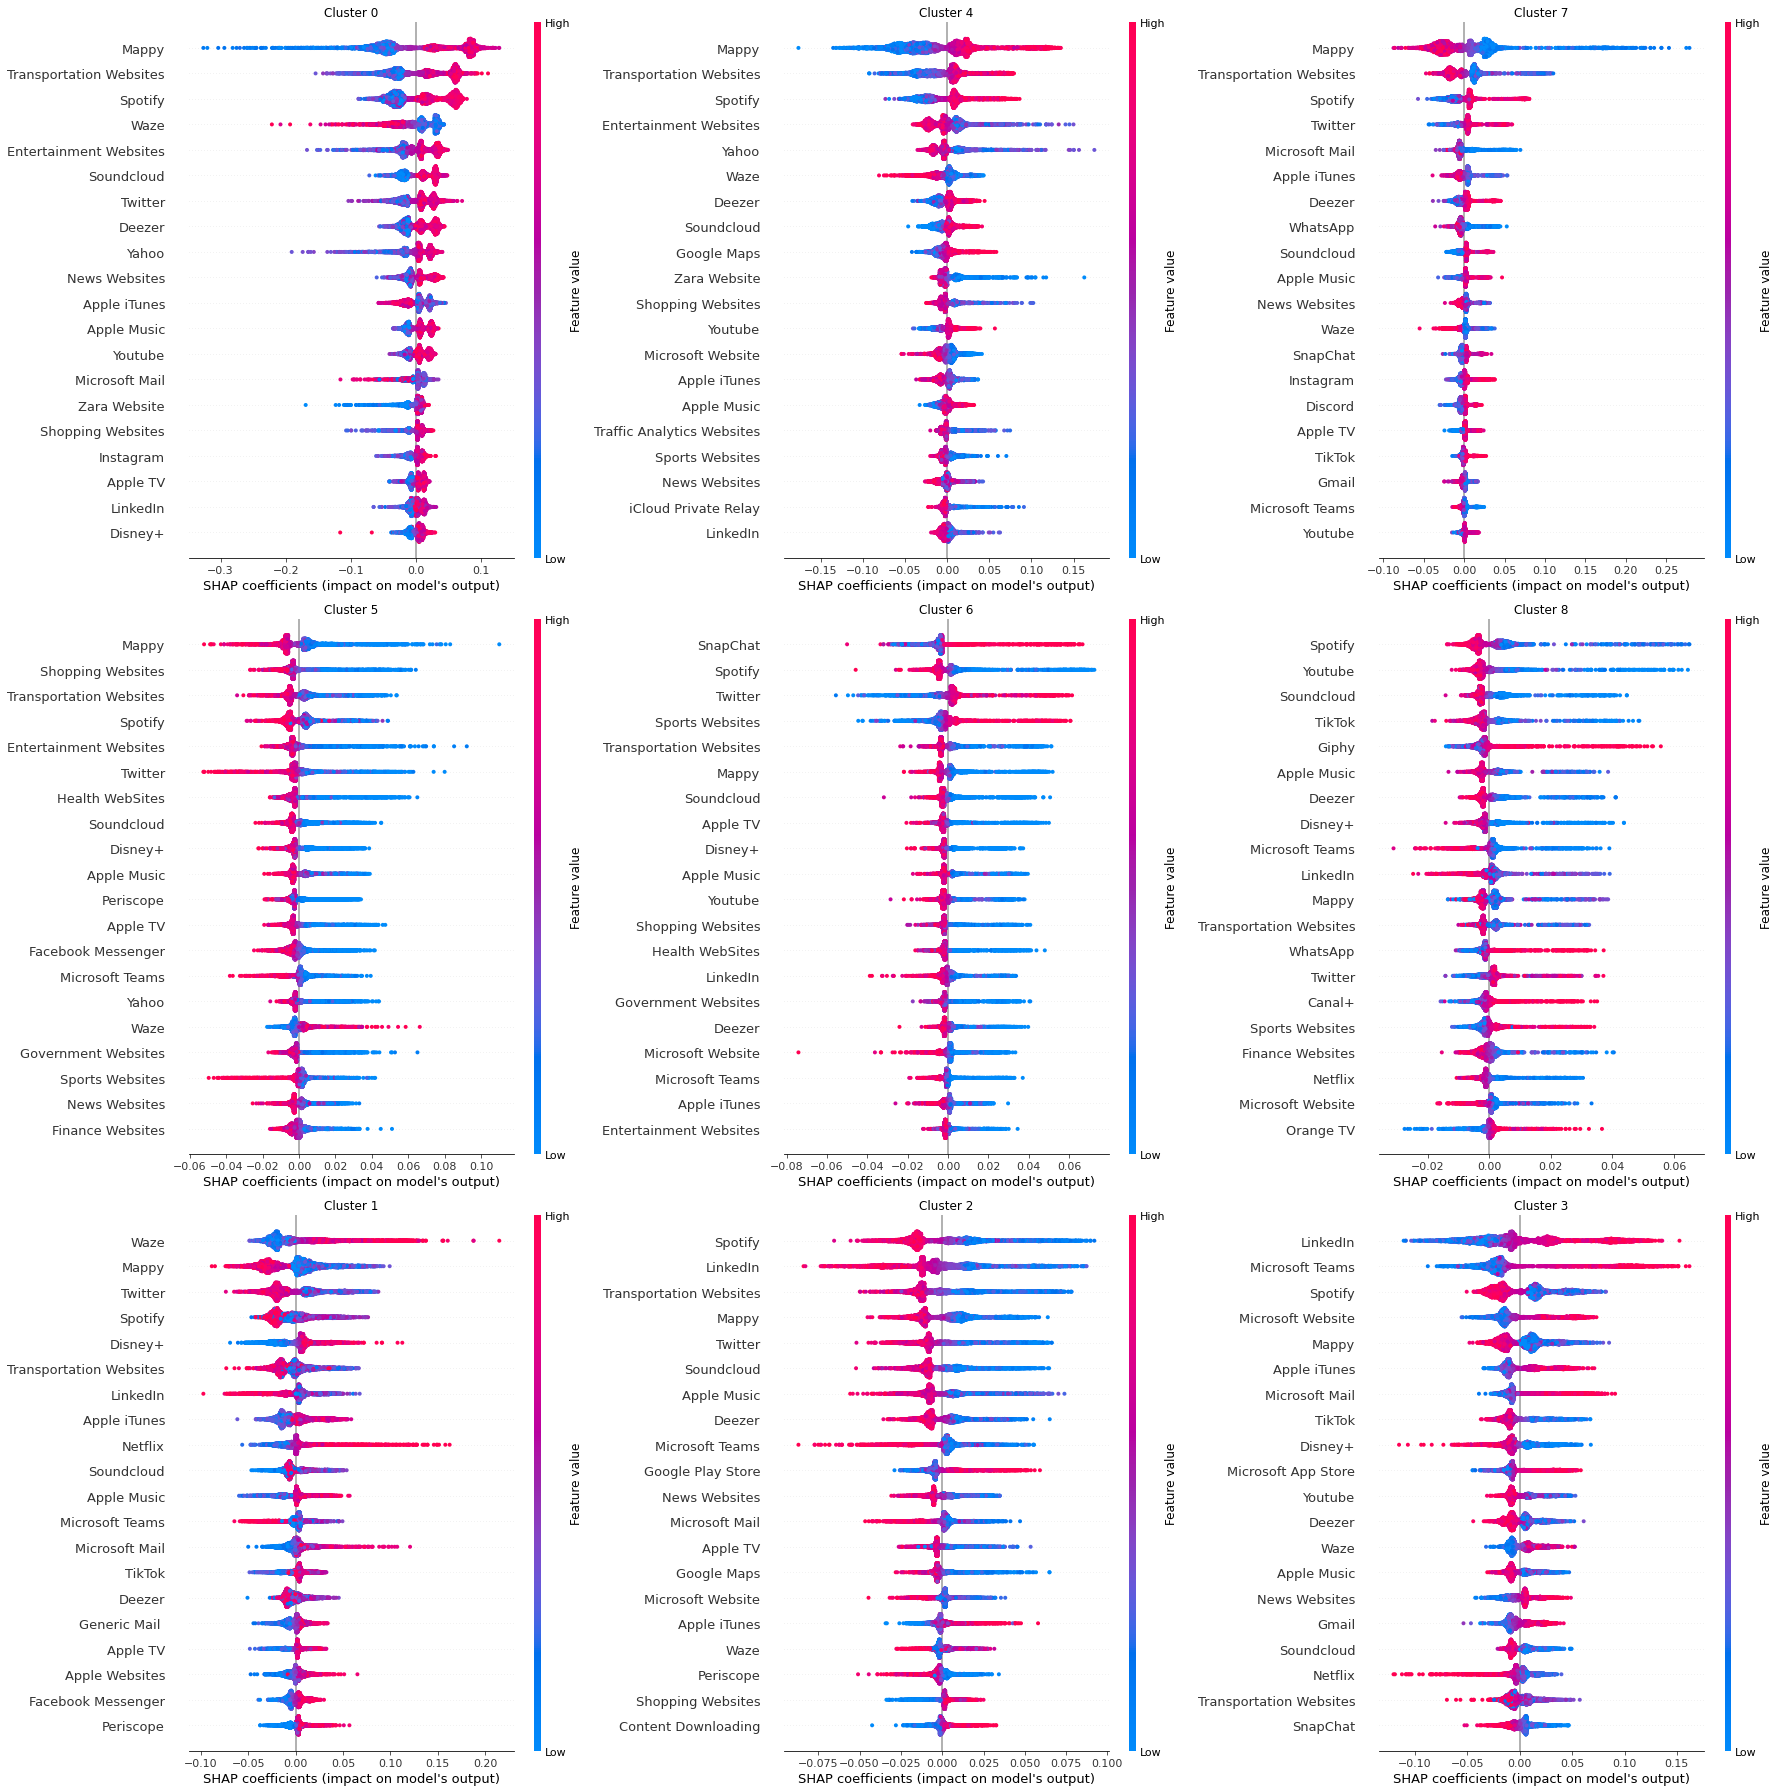

In [ ]:
plt.figure(figsize=(25,25))

group_classes = [0,4,7, 5,6,8, 1,2,3]
for i in range(classes):
    ax = plt.subplot(3, 3, i+1)
 
    shap.summary_plot(shap_values[group_classes[i]], RSCA.values, feature_names = RSCA.columns, 
                        plot_size=None, show=False)
    plt.title("Cluster " + str(group_classes[i]))
    plt.xlabel("SHAP coefficients (impact on model's output)")

# Indoor Environment Analysis

In [ ]:
#

df_RSCA["Class"] = labels
 

df_CE = df_RSCA.groupby(['Class','Environment'])['Environment'].count() 
df_EC = df_RSCA.groupby(['Environment','Class'])['Class'].count() 

environment_types  = np.unique(df_RSCA["Environment"].values)

CE_df = pd.DataFrame( np.zeros([classes ,  len (environment_types)   ] ) ,   columns=[  str(i) for i in environment_types] )
EC_df = pd.DataFrame( np.zeros([len (environment_types)  , classes ] ) ,   index = environment_types,   columns=[  str(i) for i in range(classes)] )


cnt =0 
for d in (df_CE): 
    
    CE_df.at [df_CE.index[cnt][0], df_CE.index[cnt][1] ] = d
    EC_df.at [df_CE.index[cnt][1],str(df_CE.index[cnt][0]) ] = d
    cnt = cnt+1
    
perc_df =  CE_df.div(CE_df.sum(axis=1), axis=0)  

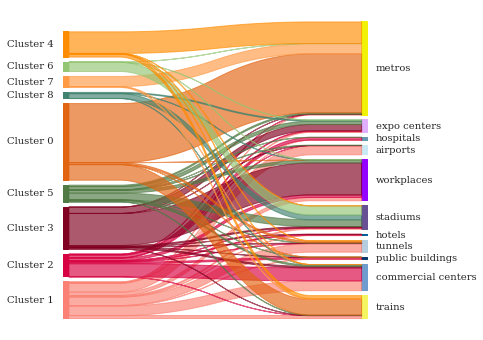

In [ ]:
# in pySankey/sankey.py:34,  change "if len(labels>0):" to "if len(labels) >0:" 
df_RSCA['Class'] = df_RSCA['Class'].replace({0: 'Cluster 0',
                              1: 'Cluster 1',
                              2: 'Cluster 2', 
                              3: 'Cluster 3',
                              4: 'Cluster 4',
                              5: 'Cluster 5',
                              6: 'Cluster 6', 
                              7: 'Cluster 7',
                              8: 'Cluster 8',
                                })      
colors = {
    "Cluster 0": "#E26310",
    "Cluster 1": "#FA8072",
    "Cluster 2": "#D70040",
    "Cluster 3": "#800020",
    "Cluster 4": "#FF8C00",
    "Cluster 5": "#4F7942",
    "Cluster 6": "#93C572",
    "Cluster 7": "#FF9944",
    "Cluster 8": "#40826D", 
    
    "trains": "#f5f55f",
    "commercial centers": "#6C9BCF", 
    "tunnels": "#b3cde0",
    "hotels": "#005b96",
    "stadiums": "#654E92",
    "workplaces": "#9300ff",
    "airports": "#c9e9f6",
    "hospitals": "#6497b1", 
    "expo centers": "#e1affd",
    "metros": "#f2f205", 
    "public buildings": "#03396c"
}


leftLabels =[  "Cluster 3", "Cluster 2", 
             "Cluster 1", "Cluster 8", 
                          "Cluster 6", "Cluster 5","Cluster 7", "Cluster 4", "Cluster 0" ]

rightLabels =[ "workplaces", "expo centers", "public buildings","hotels", "hospitals",  "commercial centers",  "tunnels", "airports",
   "stadiums",  "trains",    "metros"  ]
 
sankey(df_RSCA["Class"], df_RSCA["Environment"], aspect=20,
       colorDict=colors,   fontsize=10)

In [ ]:
perc_EC_df =  EC_df.div(EC_df.sum(axis=1), axis=0)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
      #  print(h)
        if h!=0 :
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, str(np.round(h,2)),
                ha='center', va='bottom')

def plot_EC(N, y1, y2, y3, lb1, lb2, lb3, c1, c2, c3):

    ind = np.arange(N)   
    width = 0.25     

    sns.set_style("white")
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
 

    h1 = ax.bar(ind, y1, width, color=c1, edgecolor = "k")
    h2 = ax.bar(ind+width, y2, width, color=c2, edgecolor = "k")
    h3 = ax.bar(ind+width*2, y3, width, color=c3, edgecolor = "k")
 
    plt.gca().yaxis.grid(color = "lightgray", linestyle='dashed', linewidth=0.4)
    plt.gca().xaxis.grid(False)
    ax.set_xticks(ind+width)    
    ax.tick_params(axis='y', labelsize=14)
    if N == 9: 
        ax.set_xticklabels(  np.arange (0,N ), fontsize =14 )
        plt.xlabel("Cluster ID", fontsize =14)
    else:
        ax.set_xticklabels(  environment_types, fontsize =14,  rotation='vertical' )
       # plt.xlabel("Cluster ID", fontsize =14)
    ax.legend( (h1[0], h2[0], h3[0]), (lb1, lb2, lb3) , prop = { "size": 14 })
    
 

    for axis in ['left', "bottom"]:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color("black")
        ax.spines[axis].set_zorder(0)  
    for axis in ['top','right']:
       ax.spines[axis].set_visible(False)
       ax.spines[axis].set_visible(False)
    
    autolabel(h1)
    autolabel(h2)
    autolabel(h3)
    plt.show()

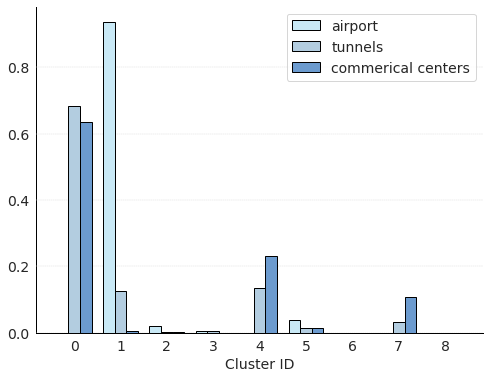

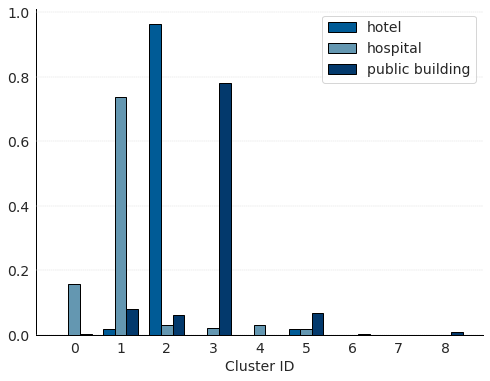

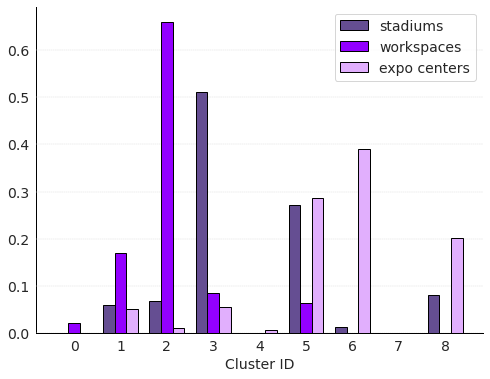

In [ ]:



plot_EC(classes, perc_EC_df.to_numpy()[0],  perc_EC_df.to_numpy()[-3],  perc_EC_df.to_numpy()[5], "airport", "tunnels", "commerical centers",'#c9e9f6' , '#b3cde0', '#6C9BCF')
plot_EC(classes, perc_EC_df.to_numpy()[3],  perc_EC_df.to_numpy()[-2],  perc_EC_df.to_numpy()[-1], "hotel", "hospital", "public building", '#005b96', '#6497b1', '#03396c')
plot_EC(classes, perc_EC_df.to_numpy()[2],  perc_EC_df.to_numpy()[6],   perc_EC_df.to_numpy()[7], "stadiums", "workspaces", "expo centers", '#654E92', '#9300ff', '#e1affd')

 

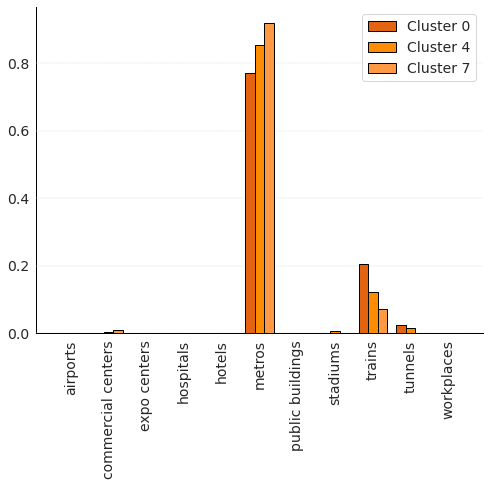

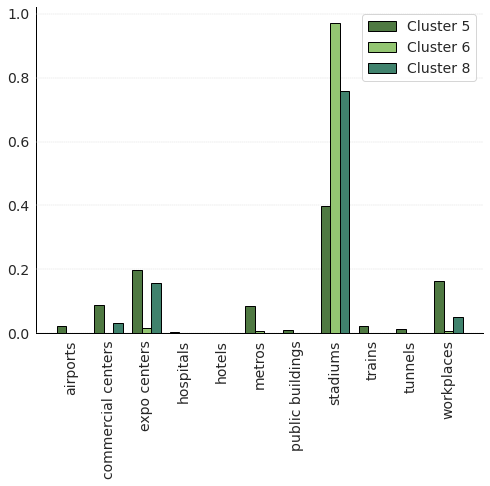

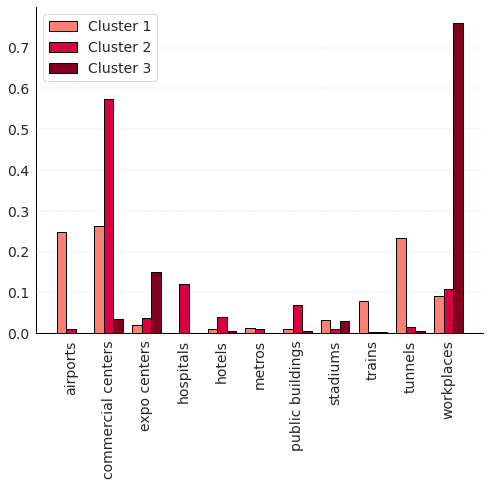

In [ ]:

perc_CE_df =  CE_df.div(CE_df.sum(axis=1), axis=0)

plot_EC( len(environment_types) , perc_CE_df.to_numpy()[0],  perc_CE_df.to_numpy()[4],  perc_CE_df.to_numpy()[7], "Cluster 0", "Cluster 4", "Cluster 7",'#E26310' , '#FF8C00', '#FF9944')
plot_EC( len(environment_types) , perc_CE_df.to_numpy()[5],  perc_CE_df.to_numpy()[6],  perc_CE_df.to_numpy()[8], "Cluster 5", "Cluster 6", "Cluster 8", '#4F7942', '#93C572', '#40826D')
plot_EC( len(environment_types) , perc_CE_df.to_numpy()[1],  perc_CE_df.to_numpy()[2],   perc_CE_df.to_numpy()[3], "Cluster 1", "Cluster 2", "Cluster 3", '#FA8072', '#D70040', '#800020')


# Comparison with Outdoor Antennas

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


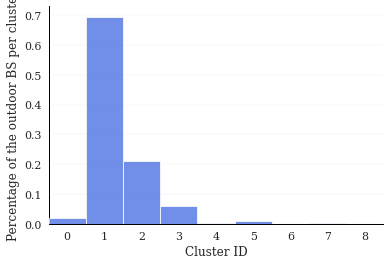

In [ ]:
RSCA_out = pd.read_csv("data/RSCA_Outdoor_Antennas.csv")
labels_out  = clf.predict(RSCA_out.values)  

fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(labels_out, bins = np.arange(0,9),   facecolor='royalblue', alpha=0.75, weights=np.ones(len(labels_out)) / len(labels_out))
plt.gca().yaxis.grid(color = "lightgray",   linestyle='dashed', linewidth=0.2)
plt.gca().xaxis.grid(False) 

ax.set_xticks( np.arange(0.5,9.5) )
ax.set_xticklabels( np.arange(0,9), fontsize = 11 )
plt.yticks(  fontsize = 11 )
ax.set_xlim([0, 9])
ax.set_xlabel("Cluster ID", fontsize = 12)
ax.set_ylabel("Percentage of the outdoor BS per cluster", fontsize = 12)
 
for axis in ['left','bottom']:
    ax.spines[axis].set_linewidth(1)
    ax.spines[axis].set_color("black")
    ax.spines[axis].set_zorder(0)  
for axis in ['top', "right"]:
    ax.spines[axis].set_visible(False)
    ax.spines[axis].set_visible(False)